In [96]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from PIL import Image

from tensorflow.keras import layers, models
from tensorflow.keras.metrics import AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

train_on_gpu = True

In [97]:
# Read data

DATA_PATH = '/kaggle/input/histopathologic-cancer-detection'

tain_df = pd.read_csv(os.path.join(DATA_PATH, 'train_labels.csv'))
samle_df = pd.read_csv(os.path.join(DATA_PATH, 'sample_submission.csv'))

tain_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [98]:
tain_df = tain_df.head(10000) # reducing number of enteries to 2% make it to run faster
tain_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10000 non-null  object
 1   label   10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [99]:
# Check distinct labels

distinct_labels = tain_df['label'].unique()

distinct_labels # array([0, 1]) - 0

array([0, 1])

In [100]:
# Lets select sample of each label category & check the shape
# 1 - c18f2d887b7ae4f6742ee445113fa1aef383ed77
# 0 - 068aba587a4950175d04c680d38943fd488d6a9d

positive_sample = Image.open(os.path.join(DATA_PATH, "train", "c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif"))
print(f"Cancerous image shape -> {np.array(positive_sample).shape}")

negative_sample = Image.open(os.path.join(DATA_PATH, "train", "755db6279dae599ebb4d39a9123cce439965282d.tif"))
print(f"Non-Cancerous image shape -> {np.array(negative_sample).shape}")


IMAGE_SIZE = 96 # image size is 96

Cancerous image shape -> (96, 96, 3)
Non-Cancerous image shape -> (96, 96, 3)


In [101]:
def display_sample_images(random_samples):
    img = plt.figure(figsize=(25, 4))
    i = 0
    for train_image in random_samples:
        ax = img.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
        im = Image.open(os.path.join(DATA_PATH, "train", f"{train_image}.tif"))
        plt.imshow(im)
        
        i += 1

Cancerous Images - Samples


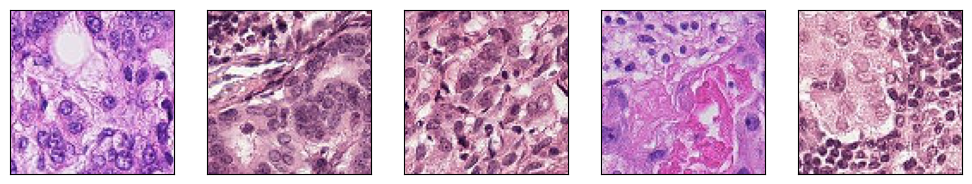

In [102]:
print("Cancerous Images - Samples")
display_sample_images(tain_df[tain_df['label'] == 1]['id'].sample(n=5, replace=False).tolist())

Non-Cancerous Images - Samples


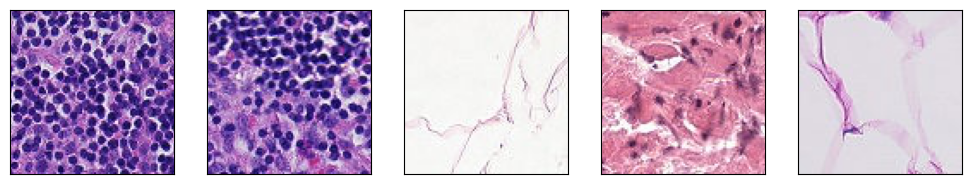

In [103]:
print("Non-Cancerous Images - Samples")
display_sample_images(tain_df[tain_df['label'] == 0]['id'].sample(n=5, replace=False).tolist())

### Exploratory Data Analysis (EDA) — Inspect, Visualize & Clean

In [104]:
# Exploring the distribution of labels in the training dataset.
tain_df['label_name'] = tain_df['label'].map({0: 'Non-Cancerous', 1: 'Cancerous'}) # Giving name to label
tain_df['image'] = os.path.join(DATA_PATH, "train") + '/' + tain_df['id'] + '.tif' # new column with image absolute path

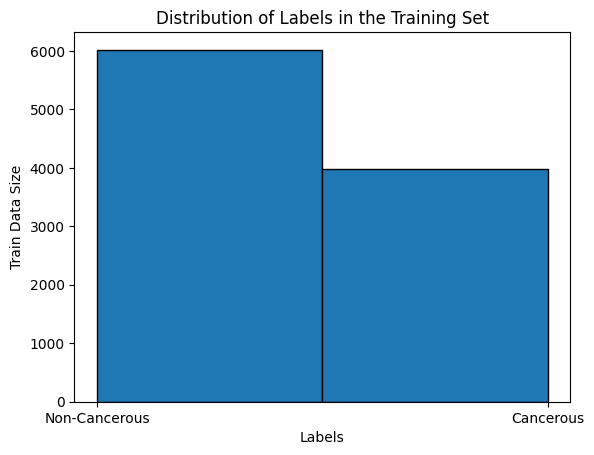

In [105]:
plt.hist(tain_df['label'], bins=2, edgecolor='black')
plt.xticks([0, 1], ['Non-Cancerous', 'Cancerous'])
plt.xlabel('Labels')
plt.ylabel('Train Data Size')
plt.title('Distribution of Labels in the Training Set')
plt.show()

Lets load the image data itself and perform a train-validation split

The data generator utilizes batch loading, loading images into memory as required for each batch and replacing them when the subsequent batch is processed. This approach alleviates memory strain during training. Additionally, the ImageDataGenerator() object rescales the RGB pixels within each image to range between 0 and 1, while also executing a 70 : 30 validation split.


In [106]:
datagenerator = ImageDataGenerator(rescale=1./255, validation_split=0.3)

In [107]:
train_generator = datagenerator.flow_from_dataframe(
    dataframe=tain_df,
    x_col="image",
    y_col="label_name",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="training",
    validate_filenames=False
)

Found 7000 non-validated image filenames belonging to 2 classes.


In [108]:
validation_generator = datagenerator.flow_from_dataframe(
    dataframe=tain_df,
    x_col="image",
    y_col="label_name",
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    class_mode="binary",
    subset="validation",
    validate_filenames=False
)

Found 3000 non-validated image filenames belonging to 2 classes.


In [109]:
# Generate - Test data Set
TEST_DATA_DIR = os.path.join(DATA_PATH, "test")

test_df = pd.DataFrame({'image': os.listdir(TEST_DATA_DIR)})
test_df['image'] = os.path.join(TEST_DATA_DIR) + '/' + test_df['image']


test_generator = datagenerator.flow_from_dataframe(
    dataframe=test_df,
    x_col='image',
    y_col=None,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    color_mode="rgb",
    batch_size=32,
    shuffle=False,
    class_mode=None,
    validate_filenames=False
)

Found 57458 non-validated image filenames.


## Modeling

#### Basic CNN

Classify the data using a sequential, dense neural network, as covered in earlier modules. The network architecture includes a flattening layer to convert the input into an array, followed by dense, fully connected layers of sizes 128, 64, 32, and 16, each employing a 'relu' activation function. Finally, the network concludes with an output layer featuring a 'sigmoid' activation function.

In [110]:
basic_cnn_model = models.Sequential()

basic_cnn_model.add(layers.Flatten(input_shape=(96, 96, 3)))

basic_cnn_model.add(layers.Dense(128, activation='relu'))
basic_cnn_model.add(layers.Dense(64, activation='relu'))
basic_cnn_model.add(layers.Dense(32, activation='relu'))
basic_cnn_model.add(layers.Dense(16, activation='relu'))

basic_cnn_model.add(layers.Dense(1, activation='sigmoid'))

basic_cnn_model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 27648)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 128)            │     3,539,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,549,953 (13.54 MB)

 Trainable params: 3,549,953 (13.54 MB)

 Non-trainable params: 0 (0.00 B)

In [111]:
basic_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

basic_cnn_history = basic_cnn_model.fit(train_generator, epochs=5, validation_data=validation_generator)

Epoch 1/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 29s 119ms/step - accuracy: 0.5482 - auc: 0.5430 - loss: 0.9615 - val_accuracy: 0.6000 - val_auc: 0.6379 - val_loss: 0.6486
Epoch 2/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 22s 97ms/step - accuracy: 0.5945 - auc: 0.6125 - loss: 0.6999 - val_accuracy: 0.6170 - val_auc: 0.6568 - val_loss: 0.6329
Epoch 3/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 41s 95ms/step - accuracy: 0.6255 - auc: 0.6669 - loss: 0.6242 - val_accuracy: 0.5957 - val_auc: 0.6284 - val_loss: 0.7240
Epoch 4/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 27s 121ms/step - accuracy: 0.6153 - auc: 0.6412 - loss: 0.6486 - val_accuracy: 0.6080 - val_auc: 0.6745 - val_loss: 0.6380
Epoch 5/5
219/219 ━━━━━━━━━━━━━━━━━━━━ 42s 127ms/step - accuracy: 0.6392 - auc: 0.6908 - loss: 0.6169 - val_accuracy: 0.5977 - val_auc: 0.6215 - val_loss: 0.8008


In [112]:
def performance_plot(history, model):
    """
    Helper method to performance plots
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))

    # Accuracy
    ax1.plot(history.history['accuracy'], label = 'Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.set_xticks(np.arange(0, 5, 1))
    ax1.set_title('Accuracy by Epoch')
    ax1.legend(loc='lower right')

    # Loss
    ax2.plot(history.history['loss'], label = 'Training Loss')
    ax2.plot(history.history['val_loss'], label = 'Validation Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.set_xticks(np.arange(0, 5, 1))
    ax2.set_title('Loss by Epoch')
    ax2.legend(loc='lower right')

    # AUC
    ax3.plot(history.history['auc'], label = 'Training AUC')
    ax3.plot(history.history['val_auc'], label = 'Validation AUC')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('AUC')
    ax3.set_xticks(np.arange(0, 5, 1))
    ax3.set_title('AUC by Epoch')
    ax3.legend(loc='lower right')

    fig.suptitle(f'{model} - Measuring Dense, Sequential Net Performance')
    plt.show()

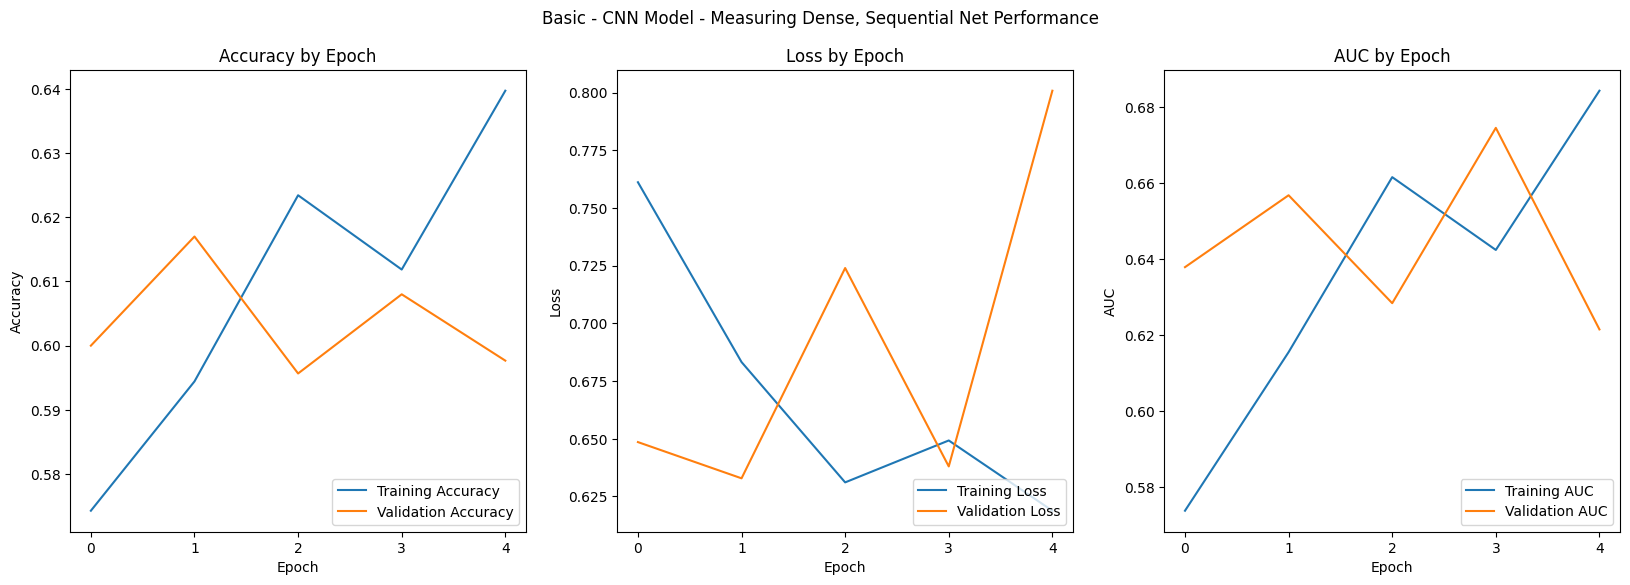

In [113]:
# Plotting
performance_plot(basic_cnn_history, 'Basic - CNN Model')

In [114]:
# Predication
prediction_labels = basic_cnn_model.predict(test_generator)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 492s 274ms/step


In [115]:
basic_cnn_model_pred_df = pd.DataFrame(columns=['id', 'label'])

basic_cnn_model_pred_df['id'] = [filename.split('.')[0] for filename in os.listdir(TEST_DATA_DIR)]
basic_cnn_model_pred_df['label'] = np.round(prediction_labels.flatten()).astype('int')

basic_cnn_model_pred_df.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,1
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


Although it seemed that the model might have started to overfit after the completion of the third epoch, indicated by the decrease in validation accuracy and increase in loss, the results from the fourth and fifth epochs suggested that there was still potential for improvement in the neural network's predictive ability.

Unfortunately, due to constraints on memory and time used only 5 epochs. The training metrics seem to be reaching a point of diminishing returns, making it intriguing to see how the validation metrics would have responded.

While this model performs adequately, its architecture is limited to processing raw pixels and lacks the ability to interpret the proximity of pixels or larger structures. Thus, I am confident that when we test a CNN next, it will surpass the performance of this model.

#### CNN Model - Average pooling

Average pooling is commonly employed in CNN architectures, usually after convolutional layers, to progressively decrease the spatial dimensions (width, height) of the feature maps while increasing the depth. This facilitates capturing more abstract features in the later layers of the network.

In [116]:
avg_pooling_cnn_model = models.Sequential()

avg_pooling_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))

avg_pooling_cnn_model.add(layers.AveragePooling2D((2, 2)))
avg_pooling_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu'))

avg_pooling_cnn_model.add(layers.AveragePooling2D((2, 2)))
avg_pooling_cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

avg_pooling_cnn_model.add(layers.Flatten())

avg_pooling_cnn_model.add(layers.Dense(128, activation='relu'))
avg_pooling_cnn_model.add(layers.Dense(1, activation='sigmoid'))

In [117]:
avg_pooling_cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', AUC(name='auc')])

avg_pooling_cnn_history = avg_pooling_cnn_model.fit(train_generator, epochs=3, validation_data=validation_generator)

Epoch 1/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 55s 240ms/step - accuracy: 0.6320 - auc: 0.6383 - loss: 0.6389 - val_accuracy: 0.7103 - val_auc: 0.8205 - val_loss: 0.5551
Epoch 2/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 52s 236ms/step - accuracy: 0.7615 - auc: 0.8257 - loss: 0.5041 - val_accuracy: 0.7587 - val_auc: 0.8361 - val_loss: 0.5143
Epoch 3/3
219/219 ━━━━━━━━━━━━━━━━━━━━ 51s 230ms/step - accuracy: 0.7718 - auc: 0.8346 - loss: 0.4901 - val_accuracy: 0.7727 - val_auc: 0.8300 - val_loss: 0.5016


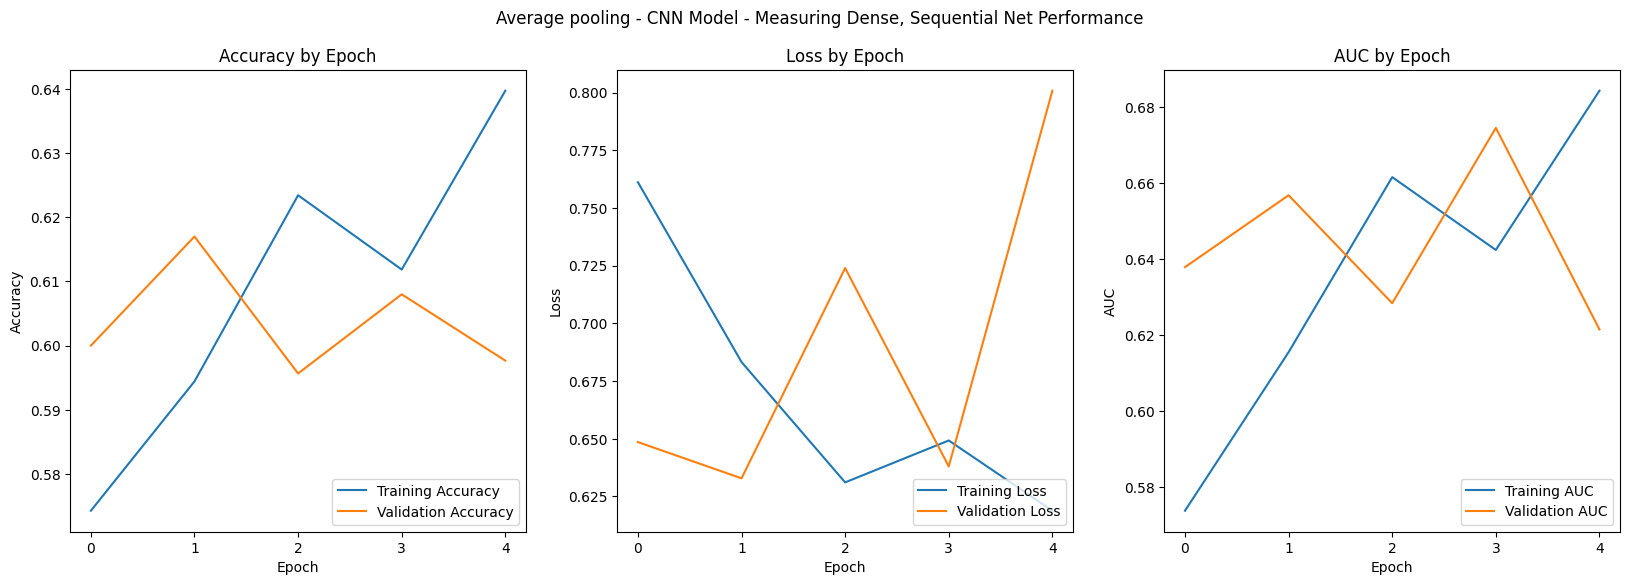

In [118]:
# Plotting

performance_plot(basic_cnn_history, 'Average pooling - CNN Model')

In [119]:
# Predication

prediction_labels = avg_pooling_cnn_model.predict(test_generator)

avg_pooling_cnn_model_pred_df = pd.DataFrame(columns=['id', 'label'])

avg_pooling_cnn_model_pred_df['id'] = [filename.split('.')[0] for filename in os.listdir(TEST_DATA_DIR)]
avg_pooling_cnn_model_pred_df['label'] = np.round(prediction_labels.flatten()).astype('int')

avg_pooling_cnn_model_pred_df.head()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 196s 109ms/step


,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,1
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,1
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,0
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


Implementing the CNN with average pooling performs well, Across the training period the average pooling CNN tends to be a slighly worse version of the max pooling CNN.

### Save predicutions

In [ ]:
basic_cnn_csv = basic_cnn_model_pred_df.to_csv('basic_cnn.csv', index=False)

In [ ]:
basic_cnn_csv